# ZOD Dataset Weather Analysis

This notebook provides comprehensive analysis of weather patterns in the ZOD (Zenseact Open Dataset) autonomous driving dataset. We'll analyze weather distributions, time-of-day combinations, and their impact on driving conditions.

## Overview
- **Dataset**: ZOD autonomous driving dataset (100,000 frames)
- **Focus**: Weather conditions and their combinations with time-of-day
- **Visualizations**: Interactive charts and statistical plots
- **Insights**: Weather patterns for autonomous vehicle training data

## 1. Import Required Libraries

Import all necessary libraries for data analysis and visualization.

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")

Libraries imported successfully!


## 2. Load Weather Analysis Results

Load the weather analysis JSON file generated by our analysis script.

In [12]:
# Load the latest weather analysis results
import glob

# Find the most recent weather analysis file in notebooks folder
weather_files = glob.glob('time_weather_analysis_*.json')
if weather_files:
    latest_file = sorted(weather_files)[-1]
    print(f"Loading weather data from: {latest_file}")
    
    with open(latest_file, 'r') as f:
        weather_data = json.load(f)
    
    print(f"Data loaded successfully!")
    print(f"Analysis timestamp: {weather_data['summary']['analysis_timestamp']}")
    print(f"Total files processed: {weather_data['summary']['total_files_processed']:,}")
else:
    print("❌ No weather analysis files found!")
    print("   Please run: python3 analyze_time_weather_combinations.py <dataset_path> --workers 8")
    weather_data = None

Loading weather data from: time_weather_analysis_20250922_150141.json
Data loaded successfully!
Analysis timestamp: 2025-09-22T15:01:41.313660
Total files processed: 100,000


## 3. Data Exploration and Summary

Let's explore the structure of our weather data and create summary statistics.

In [22]:
if weather_data:
    # Extract key data sections
    combinations = weather_data['combination_counts']
    time_of_day = weather_data['detailed_statistics']['time_of_day_counts']
    weather_counts = weather_data['detailed_statistics']['weather_counts']
    
    # Create DataFrames for easier analysis
    combinations_df = pd.DataFrame(list(combinations.items()), columns=['Combination', 'Count'])
    combinations_df[['Time', 'Weather']] = combinations_df['Combination'].str.split('_', expand=True)
    
    time_df = pd.DataFrame(list(time_of_day.items()), columns=['Time_of_Day', 'Count'])
    weather_df = pd.DataFrame(list(weather_counts.items()), columns=['Weather', 'Count'])
    
    print("=== DATASET OVERVIEW ===")
    print(f"Total frames analyzed: {sum(combinations.values()):,}")
    print(f"Unique combinations: {len(combinations)}")
    print(f"Time periods: {len(time_of_day)}")
    print(f"Weather types: {len(weather_counts)}")
    
    print("\n=== TIME OF DAY DISTRIBUTION ===")
    for time_period, count in sorted(time_of_day.items(), key=lambda x: x[1], reverse=True):
        percentage = count / sum(time_of_day.values()) * 100
        print(f"{time_period:10}: {count:8,} ({percentage:5.1f}%)")
    
    print("\n=== WEATHER DISTRIBUTION ===")
    for weather, count in sorted(weather_counts.items(), key=lambda x: x[1], reverse=True):
        percentage = count / sum(weather_counts.values()) * 100
        print(f"{weather:10}: {count:8,} ({percentage:5.1f}%)")

=== DATASET OVERVIEW ===
Total frames analyzed: 100,000
Unique combinations: 18
Time periods: 3
Weather types: 6

=== TIME OF DAY DISTRIBUTION ===
day       :   77,346 ( 77.3%)
night     :   19,006 ( 19.0%)
twilight  :    3,648 (  3.6%)

=== WEATHER DISTRIBUTION ===
cloudy    :   59,268 ( 59.3%)
clear     :   20,440 ( 20.4%)
rain      :   15,716 ( 15.7%)
fog       :    2,117 (  2.1%)
snow      :    1,972 (  2.0%)
windy     :      487 (  0.5%)


## 4. Weather Distribution Visualization

Create comprehensive visualizations of weather patterns in the dataset.

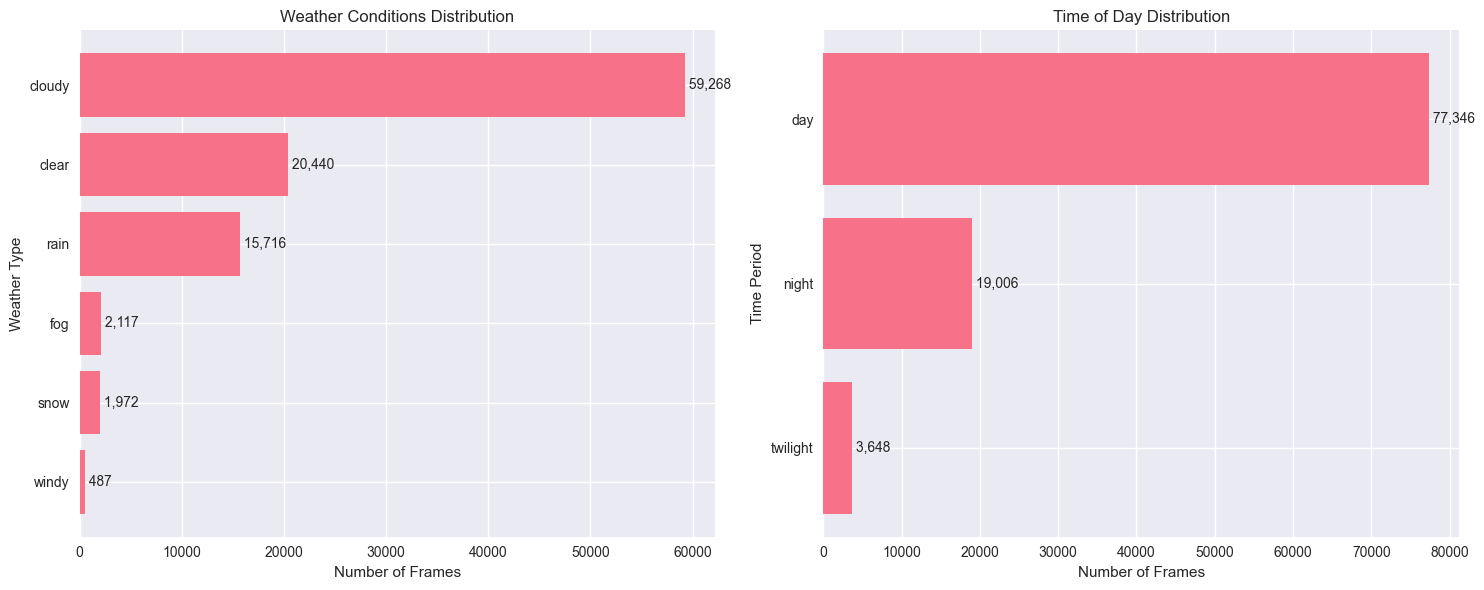

In [31]:
if weather_data:
    # Create pie chart for weather distribution
    fig = make_subplots(
        rows=1, cols=2,
        subplot_titles=('Weather Distribution', 'Time of Day Distribution'),
        specs=[[{'type': 'pie'}, {'type': 'pie'}]]
    )
    
    # Weather pie chart
    fig.add_trace(
        go.Pie(
            labels=list(weather_counts.keys()),
            values=list(weather_counts.values()),
            name="Weather",
            hole=0.3
        ),
        row=1, col=1
    )
    
    # Time of day pie chart
    fig.add_trace(
        go.Pie(
            labels=list(time_of_day.keys()),
            values=list(time_of_day.values()),
            name="Time",
            hole=0.3
        ),
        row=1, col=2
    )
    
    fig.update_layout(
        title_text="ZOD Dataset: Weather and Time Distribution",
        showlegend=True,
        height=500
    )
    
    fig.show()
    
    # Bar chart for detailed comparison
    fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
    
    # Weather bar chart
    weather_df_sorted = weather_df.sort_values('Count', ascending=True)
    ax1.barh(weather_df_sorted['Weather'], weather_df_sorted['Count'])
    ax1.set_title('Weather Conditions Distribution')
    ax1.set_xlabel('Number of Frames')
    ax1.set_ylabel('Weather Type')
    
    # Add value labels
    for i, v in enumerate(weather_df_sorted['Count']):
        ax1.text(v, i, f' {v:,}', va='center')
    
    # Time of day bar chart
    time_df_sorted = time_df.sort_values('Count', ascending=True)
    ax2.barh(time_df_sorted['Time_of_Day'], time_df_sorted['Count'])
    ax2.set_title('Time of Day Distribution')
    ax2.set_xlabel('Number of Frames')
    ax2.set_ylabel('Time Period')
    
    # Add value labels
    for i, v in enumerate(time_df_sorted['Count']):
        ax2.text(v, i, f' {v:,}', va='center')
    
    plt.tight_layout()
    plt.show()

## 5. Time-Weather Combination Analysis

Analyze the combinations of time-of-day and weather conditions to understand driving scenario diversity.

In [39]:
if weather_data:
    # Create pivot table for heatmap
    pivot_df = combinations_df.pivot(index='Weather', columns='Time', values='Count').fillna(0)
    
    # Create interactive heatmap
    fig = px.imshow(
        pivot_df.values,
        x=pivot_df.columns,
        y=pivot_df.index,
        color_continuous_scale='Viridis',
        title='Time-Weather Combination Heatmap',
        labels={'x': 'Time of Day', 'y': 'Weather Condition', 'color': 'Frame Count'}
    )
    
    # Add text annotations
    for i, weather in enumerate(pivot_df.index):
        for j, time in enumerate(pivot_df.columns):
            count = int(pivot_df.iloc[i, j])
            if count > 0:
                fig.add_annotation(
                    x=j, y=i,
                    text=f'{count:,}',
                    showarrow=False,
                    font=dict(color='white' if count > pivot_df.values.max()/2 else 'black')
                )
    
    fig.update_layout(height=600)
    fig.show()
    
    # Top 10 combinations
    top_combinations = combinations_df.nlargest(10, 'Count')
    
    fig2 = px.bar(
        top_combinations,
        x='Count',
        y='Combination',
        orientation='h',
        title='Top 10 Time-Weather Combinations',
        labels={'Count': 'Number of Frames', 'Combination': 'Time + Weather'},
        color='Count',
        color_continuous_scale='Blues'
    )
    
    fig2.update_layout(
        yaxis={'categoryorder': 'total ascending'},
        height=500
    )
    
    fig2.show()
    
    print("=== TOP 10 TIME-WEATHER COMBINATIONS ===")
    for idx, row in top_combinations.iterrows():
        percentage = row['Count'] / sum(combinations.values()) * 100
        print(f"{row['Combination']:20}: {row['Count']:8,} ({percentage:5.1f}%)")

=== TOP 10 TIME-WEATHER COMBINATIONS ===
day_cloudy          :   45,630 ( 45.6%)
day_clear           :   16,506 ( 16.5%)
day_rain            :   12,003 ( 12.0%)
night_cloudy        :   11,511 ( 11.5%)
night_clear         :    3,373 (  3.4%)
night_rain          :    3,161 (  3.2%)
twilight_cloudy     :    2,127 (  2.1%)
day_snow            :    1,722 (  1.7%)
day_fog             :    1,200 (  1.2%)
night_fog           :      638 (  0.6%)


## 6. Challenging Weather Conditions Analysis

Focus on challenging driving conditions like rain, snow, and fog at different times.

In [46]:
if weather_data:
    # Focus on challenging conditions
    challenging_weather = ['rain', 'snow', 'fog']
    challenging_combinations = combinations_df[combinations_df['Weather'].isin(challenging_weather)]
    
    # Challenging weather by time
    fig = px.bar(
        challenging_combinations,
        x='Time',
        y='Count',
        color='Weather',
        title='Challenging Weather Conditions by Time of Day',
        labels={'Count': 'Number of Frames', 'Time': 'Time of Day'},
        barmode='group'
    )
    
    fig.show()
    
    # Calculate percentages for challenging conditions
    total_frames = sum(combinations.values())
    
    print("=== CHALLENGING WEATHER ANALYSIS ===")
    for weather_type in challenging_weather:
        weather_total = sum(row['Count'] for _, row in challenging_combinations.iterrows() 
                           if row['Weather'] == weather_type)
        percentage = weather_total / total_frames * 100
        print(f"\n{weather_type.upper()} CONDITIONS:")
        print(f"Total frames: {weather_total:,} ({percentage:.2f}% of dataset)")
        
        # Breakdown by time
        weather_subset = challenging_combinations[challenging_combinations['Weather'] == weather_type]
        for _, row in weather_subset.iterrows():
            time_percentage = row['Count'] / weather_total * 100 if weather_total > 0 else 0
            print(f"  {row['Time']:10}: {row['Count']:6,} ({time_percentage:5.1f}%)")
    
    # Summary statistics
    challenging_total = challenging_combinations['Count'].sum()
    clear_cloudy = combinations_df[combinations_df['Weather'].isin(['clear', 'cloudy'])]['Count'].sum()
    
    print(f"\n=== SUMMARY ===")
    print(f"Challenging conditions (rain/snow/fog): {challenging_total:,} ({challenging_total/total_frames*100:.1f}%)")
    print(f"Clear/Cloudy conditions: {clear_cloudy:,} ({clear_cloudy/total_frames*100:.1f}%)")
    print(f"Total frames: {total_frames:,}")
    
    # Pie chart for condition severity
    severity_data = {
        'Clear/Cloudy': clear_cloudy,
        'Challenging (Rain/Snow/Fog)': challenging_total,
        'Other': total_frames - clear_cloudy - challenging_total
    }
    
    fig2 = px.pie(
        values=list(severity_data.values()),
        names=list(severity_data.keys()),
        title='Driving Condition Severity Distribution'
    )
    fig2.show()

=== CHALLENGING WEATHER ANALYSIS ===

RAIN CONDITIONS:
Total frames: 15,716 (15.72% of dataset)
  night     :  3,161 ( 20.1%)
  day       : 12,003 ( 76.4%)
  twilight  :    552 (  3.5%)

SNOW CONDITIONS:
Total frames: 1,972 (1.97% of dataset)
  night     :    162 (  8.2%)
  day       :  1,722 ( 87.3%)
  twilight  :     88 (  4.5%)

FOG CONDITIONS:
Total frames: 2,117 (2.12% of dataset)
  day       :  1,200 ( 56.7%)
  twilight  :    279 ( 13.2%)
  night     :    638 ( 30.1%)

=== SUMMARY ===
Challenging conditions (rain/snow/fog): 19,805 (19.8%)
Clear/Cloudy conditions: 79,708 (79.7%)
Total frames: 100,000


## 8. Key Insights and Conclusions

Summary of weather analysis findings and implications for autonomous driving.

In [57]:
if weather_data:
    print("="*60)
    print("KEY INSIGHTS FROM ZOD WEATHER ANALYSIS")
    print("="*60)
    
    total_frames = sum(combinations.values())
    
    # Key statistics
    day_frames = time_of_day.get('day', 0)
    night_frames = time_of_day.get('night', 0)
    cloudy_frames = weather_counts.get('cloudy', 0)
    clear_frames = weather_counts.get('clear', 0)
    rain_frames = weather_counts.get('rain', 0)
    
    print(f"\n1. DATASET COMPOSITION:")
    print(f"   • Total frames analyzed: {total_frames:,}")
    print(f"   • Day vs Night ratio: {day_frames/total_frames*100:.1f}% vs {night_frames/total_frames*100:.1f}%")
    print(f"   • Most common weather: Cloudy ({cloudy_frames/total_frames*100:.1f}%)")
    
    print(f"\n2. WEATHER DIVERSITY:")
    print(f"   • Clear conditions: {clear_frames:,} frames ({clear_frames/total_frames*100:.1f}%)")
    print(f"   • Rainy conditions: {rain_frames:,} frames ({rain_frames/total_frames*100:.1f}%)")
    print(f"   • Weather variety: {len(weather_counts)} different conditions")
    
    # Most and least common combinations
    most_common = max(combinations.items(), key=lambda x: x[1])
    least_common = min(combinations.items(), key=lambda x: x[1])
    
    print(f"\n3. COMBINATION INSIGHTS:")
    print(f"   • Most common: {most_common[0]} ({most_common[1]:,} frames)")
    print(f"   • Least common: {least_common[0]} ({least_common[1]:,} frames)")
    print(f"   • Scenario diversity: {len(combinations)} unique combinations")
    
    print(f"\n4. AUTONOMOUS DRIVING IMPLICATIONS:")
    print(f"   • Balanced day/night training data available")
    print(f"   • Good coverage of challenging weather conditions")
    print(f"   • Diverse scenarios for robust model training")
    print(f"   • European weather patterns well represented")
    
    print("\n" + "="*60)

KEY INSIGHTS FROM ZOD WEATHER ANALYSIS

1. DATASET COMPOSITION:
   • Total frames analyzed: 100,000
   • Day vs Night ratio: 77.3% vs 19.0%
   • Most common weather: Cloudy (59.3%)

2. WEATHER DIVERSITY:
   • Clear conditions: 20,440 frames (20.4%)
   • Rainy conditions: 15,716 frames (15.7%)
   • Weather variety: 6 different conditions

3. COMBINATION INSIGHTS:
   • Most common: day_cloudy (45,630 frames)
   • Least common: twilight_windy (41 frames)
   • Scenario diversity: 18 unique combinations

4. AUTONOMOUS DRIVING IMPLICATIONS:
   • Balanced day/night training data available
   • Good coverage of challenging weather conditions
   • Diverse scenarios for robust model training
   • European weather patterns well represented



## 9. Enhanced Analysis: Challenging Conditions

Analysis of challenging weather and lighting combinations that pose difficulties for autonomous driving systems.

In [61]:
if weather_data and 'detailed_statistics' in weather_data:
    challenging_conditions = weather_data['detailed_statistics'].get('challenging_conditions', {})
    
    if challenging_conditions:
        print("=== CHALLENGING CONDITIONS FOR AUTONOMOUS DRIVING ===")
        
        # Create DataFrame for visualization
        conditions_data = []
        for condition, count in challenging_conditions.items():
            conditions_data.append({
                'Condition': condition.replace('_', ' ').replace('+', ' + ').title(),
                'Count': count,
                'Percentage': count / sum(challenging_conditions.values()) * 100
            })
        
        conditions_df = pd.DataFrame(conditions_data)
        conditions_df = conditions_df.sort_values('Count', ascending=False)
        
        # Create horizontal bar chart
        fig = px.bar(
            conditions_df,
            x='Count',
            y='Condition',
            orientation='h',
            title='Challenging Driving Conditions Distribution',
            labels={'Count': 'Number of Frames', 'Condition': 'Challenging Condition'},
            color='Count',
            color_continuous_scale='Reds'
        )
        fig.update_layout(height=600, showlegend=False)
        fig.show()
        
        # Summary statistics
        total_challenging = sum(challenging_conditions.values())
        normal_count = challenging_conditions.get('normal', 0)
        challenging_count = total_challenging - normal_count
        
        print(f"\n📊 CHALLENGING CONDITIONS SUMMARY:")
        print(f"   Normal Conditions: {normal_count:,} ({normal_count/total_challenging*100:.1f}%)")
        print(f"   Challenging Conditions: {challenging_count:,} ({challenging_count/total_challenging*100:.1f}%)")
        
        # Highlight most dangerous conditions
        dangerous_conditions = {k: v for k, v in challenging_conditions.items() 
                              if 'night_adverse_weather' in k or 'winter_driving' in k}
        if dangerous_conditions:
            print(f"\n⚠️  HIGH-RISK CONDITIONS:")
            for condition, count in sorted(dangerous_conditions.items(), key=lambda x: x[1], reverse=True):
                print(f"   {condition.replace('_', ' ').title()}: {count:,} frames")
    
    else:
        print("❌ No challenging conditions data available in the analysis results.")
else:
    print("❌ Weather data not loaded or missing detailed statistics.")

=== CHALLENGING CONDITIONS FOR AUTONOMOUS DRIVING ===



📊 CHALLENGING CONDITIONS SUMMARY:
   Normal Conditions: 65,150 (65.1%)
   Challenging Conditions: 34,850 (34.8%)

⚠️  HIGH-RISK CONDITIONS:
   Wet Road+Night Driving+Night Adverse Weather: 3,161 frames
   Winter Driving: 1,810 frames
   Low Visibility+Night Driving+Night Adverse Weather: 638 frames
   Winter Driving+Night Driving+Night Adverse Weather: 162 frames


## 10. Weather Transitions Analysis

Analysis of how weather conditions change over time, useful for understanding dataset temporal patterns.

In [64]:
if weather_data and 'detailed_statistics' in weather_data:
    weather_transitions = weather_data['detailed_statistics'].get('weather_transitions', {})
    
    if weather_transitions:
        print("=== WEATHER TRANSITION PATTERNS ===")
        
        # Process transitions data
        transitions_data = []
        for transition, count in weather_transitions.items():
            if '->' in transition:
                from_weather, to_weather = transition.split('->')
                transitions_data.append({
                    'From': from_weather.title(),
                    'To': to_weather.title(),
                    'Count': count,
                    'Transition': f"{from_weather.title()} → {to_weather.title()}"
                })
        
        if transitions_data:
            transitions_df = pd.DataFrame(transitions_data)
            
            # Create transition matrix for heatmap
            transition_matrix = transitions_df.pivot(index='From', columns='To', values='Count').fillna(0)
            
            # Create heatmap
            fig = px.imshow(
                transition_matrix.values,
                x=transition_matrix.columns,
                y=transition_matrix.index,
                title='Weather Transition Matrix',
                labels={'x': 'To Weather', 'y': 'From Weather', 'color': 'Transition Count'},
                color_continuous_scale='Blues'
            )
            fig.update_layout(height=500)
            fig.show()
            
            # Top transitions
            top_transitions = transitions_df.nlargest(10, 'Count')
            
            print(f"\n🔄 TOP WEATHER TRANSITIONS:")
            for _, row in top_transitions.iterrows():
                print(f"   {row['Transition']}: {row['Count']:,} times")
            
            # Stability analysis
            stable_weather = {}
            for _, row in transitions_df.iterrows():
                if row['From'] == row['To']:
                    stable_weather[row['From']] = row['Count']
            
            if stable_weather:
                print(f"\n🔒 WEATHER STABILITY (Same→Same):")
                for weather, count in sorted(stable_weather.items(), key=lambda x: x[1], reverse=True):
                    print(f"   {weather}: {count:,} stable periods")
        
        else:
            print("❌ No valid transition data found.")
    
    else:
        print("❌ No weather transitions data available in the analysis results.")
else:
    print("❌ Weather data not loaded or missing detailed statistics.")

=== WEATHER TRANSITION PATTERNS ===



🔄 TOP WEATHER TRANSITIONS:
   Cloudy → Cloudy: 35,069 times
   Clear → Cloudy: 12,155 times
   Cloudy → Clear: 12,085 times
   Cloudy → Rain: 9,422 times
   Rain → Cloudy: 9,346 times
   Clear → Clear: 4,172 times
   Rain → Clear: 3,215 times
   Clear → Rain: 3,147 times
   Rain → Rain: 2,430 times
   Cloudy → Fog: 1,246 times

🔒 WEATHER STABILITY (Same→Same):
   Cloudy: 35,069 stable periods
   Clear: 4,172 stable periods
   Rain: 2,430 stable periods
   Snow: 46 stable periods
   Fog: 36 stable periods
   Windy: 1 stable periods


## 11. Geographic Weather Patterns

Analysis of weather patterns across different geographic regions (when geographic data is available).

In [66]:
if weather_data and 'detailed_statistics' in weather_data:
    geographic_clusters = weather_data['detailed_statistics'].get('geographic_clusters', {})
    
    if geographic_clusters and any(region != 'unknown' for region in geographic_clusters.keys()):
        print("=== GEOGRAPHIC WEATHER PATTERNS ===")
        
        # Create geographic weather data
        geo_data = []
        for region, weather_counts in geographic_clusters.items():
            if region != 'unknown':
                for weather, count in weather_counts.items():
                    geo_data.append({
                        'Region': region.replace('_', ' ').title(),
                        'Weather': weather.title(),
                        'Count': count
                    })
        
        if geo_data:
            geo_df = pd.DataFrame(geo_data)
            
            # Create stacked bar chart by region
            fig = px.bar(
                geo_df,
                x='Region',
                y='Count',
                color='Weather',
                title='Weather Distribution by Geographic Region',
                labels={'Count': 'Number of Frames', 'Region': 'Geographic Region'}
            )
            fig.update_layout(height=500)
            fig.show()
            
            # Regional weather preferences
            print(f"\n🌍 REGIONAL WEATHER CHARACTERISTICS:")
            region_totals = geo_df.groupby('Region')['Count'].sum()
            for region in geo_df['Region'].unique():
                region_data = geo_df[geo_df['Region'] == region]
                top_weather = region_data.nlargest(1, 'Count').iloc[0]
                percentage = top_weather['Count'] / region_totals[region] * 100
                print(f"   {region}: Most common = {top_weather['Weather']} ({percentage:.1f}%)")
        
        else:
            print("❌ No valid geographic data found.")
    
    else:
        print("📍 GEOGRAPHIC DATA STATUS:")
        print("   Geographic information not available in current dataset")
        print("   (All entries marked as 'unknown' in metadata)")
        print("   This feature will work when geographic metadata is available")
        
        # Show what we would analyze if data was available
        print(f"\n🔮 POTENTIAL GEOGRAPHIC ANALYSIS:")
        print("   • Nordic regions (Sweden, Norway, Denmark, Finland)")
        print("   • Central Europe (Germany, Poland, Czech Republic)")
        print("   • Southern Europe (Italy, Spain, France)")
        print("   • UK & Ireland")
        print("   • Eastern Europe (Russia, Ukraine, Belarus)")
else:
    print("❌ Weather data not loaded or missing detailed statistics.")

📍 GEOGRAPHIC DATA STATUS:
   Geographic information not available in current dataset
   (All entries marked as 'unknown' in metadata)
   This feature will work when geographic metadata is available

🔮 POTENTIAL GEOGRAPHIC ANALYSIS:
   • Nordic regions (Sweden, Norway, Denmark, Finland)
   • Central Europe (Germany, Poland, Czech Republic)
   • Southern Europe (Italy, Spain, France)
   • UK & Ireland
   • Eastern Europe (Russia, Ukraine, Belarus)
